# Mouse retina neuron development
# Extract biological activities by [decoupler](https://decoupler-py.readthedocs.io)

`decoupler` is a package containing different statistical methods to extract biological activities from omics data within a unified framework. It allows to flexibly test any enrichment method with any prior knowledge resource and incorporates methods that take into account the sign and weight. It can be used with any omic, as long as its features can be linked to a biological process based on prior knowledge. For example, in transcriptomics gene sets regulated by a transcription factor, or in phospho-proteomics phosphosites that are targeted by a kinase.

In [1]:
import scanpy as sc
import decoupler as dc
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import anndata
import dynamo as dyn
dyn.get_all_dependencies_version()

2023-12-13 14:50:15.731478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 14:50:16.732505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


package,tqdm,statsmodels,setuptools,scipy,scikit-learn,pandas,numpy,networkx,matplotlib,anndata,igraph,loompy,numdifftools,umap-learn,numba,seaborn,colorcet,pynndescent,pre-commit,get-version,openpyxl,typing-extensions,session-info,dynamo-release
version,4.65.0,0.14.0,68.0.0,1.10.0,1.2.2,1.5.3,1.22.3,2.8.4,3.7.1,0.9.1,0.10.4,3.0.7,0.9.41,0.5.3,0.56.4,0.12.2,3.0.1,0.5.8,3.2.0,3.5.4,3.2.0b1,4.5.0,1.0.0,1.3.3


## Load data

In [2]:
adata = anndata.read('mouse_retina_cellcommun.h5ad')

## Preprocess the Data

In [3]:
dyn.pp.recipe_monocle(adata)

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> filtering cells...
|-----> 2683 cells passed basic filters.
|-----> filtering gene...
|-----> 4836 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...
|-----> size factor normalizing the data, followed by log1p transformation.

## Pathway activity inference

### [PROGENy](https://saezlab.github.io/progeny/) model for pathway activity inference
`PROGENy` is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. 

In [4]:
progeny = dc.get_progeny(organism='human', top=500)

In [6]:
adata.raw = adata

### run activity inference with multivariate linear model (MLM)

In [7]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

14627 features of mat are empty, they will be removed.
Running mlm on mat with 2726 samples and 16426 targets for 14 sources.


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


In [8]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')

# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 2726 × 14
    obs: 'Clusters', 'Annotation', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'mean', 'std'
    uns: 'paper_review_url', 'paper_url', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_scores', 'mlm_estimate', 'mlm_pvals'

### Visualization

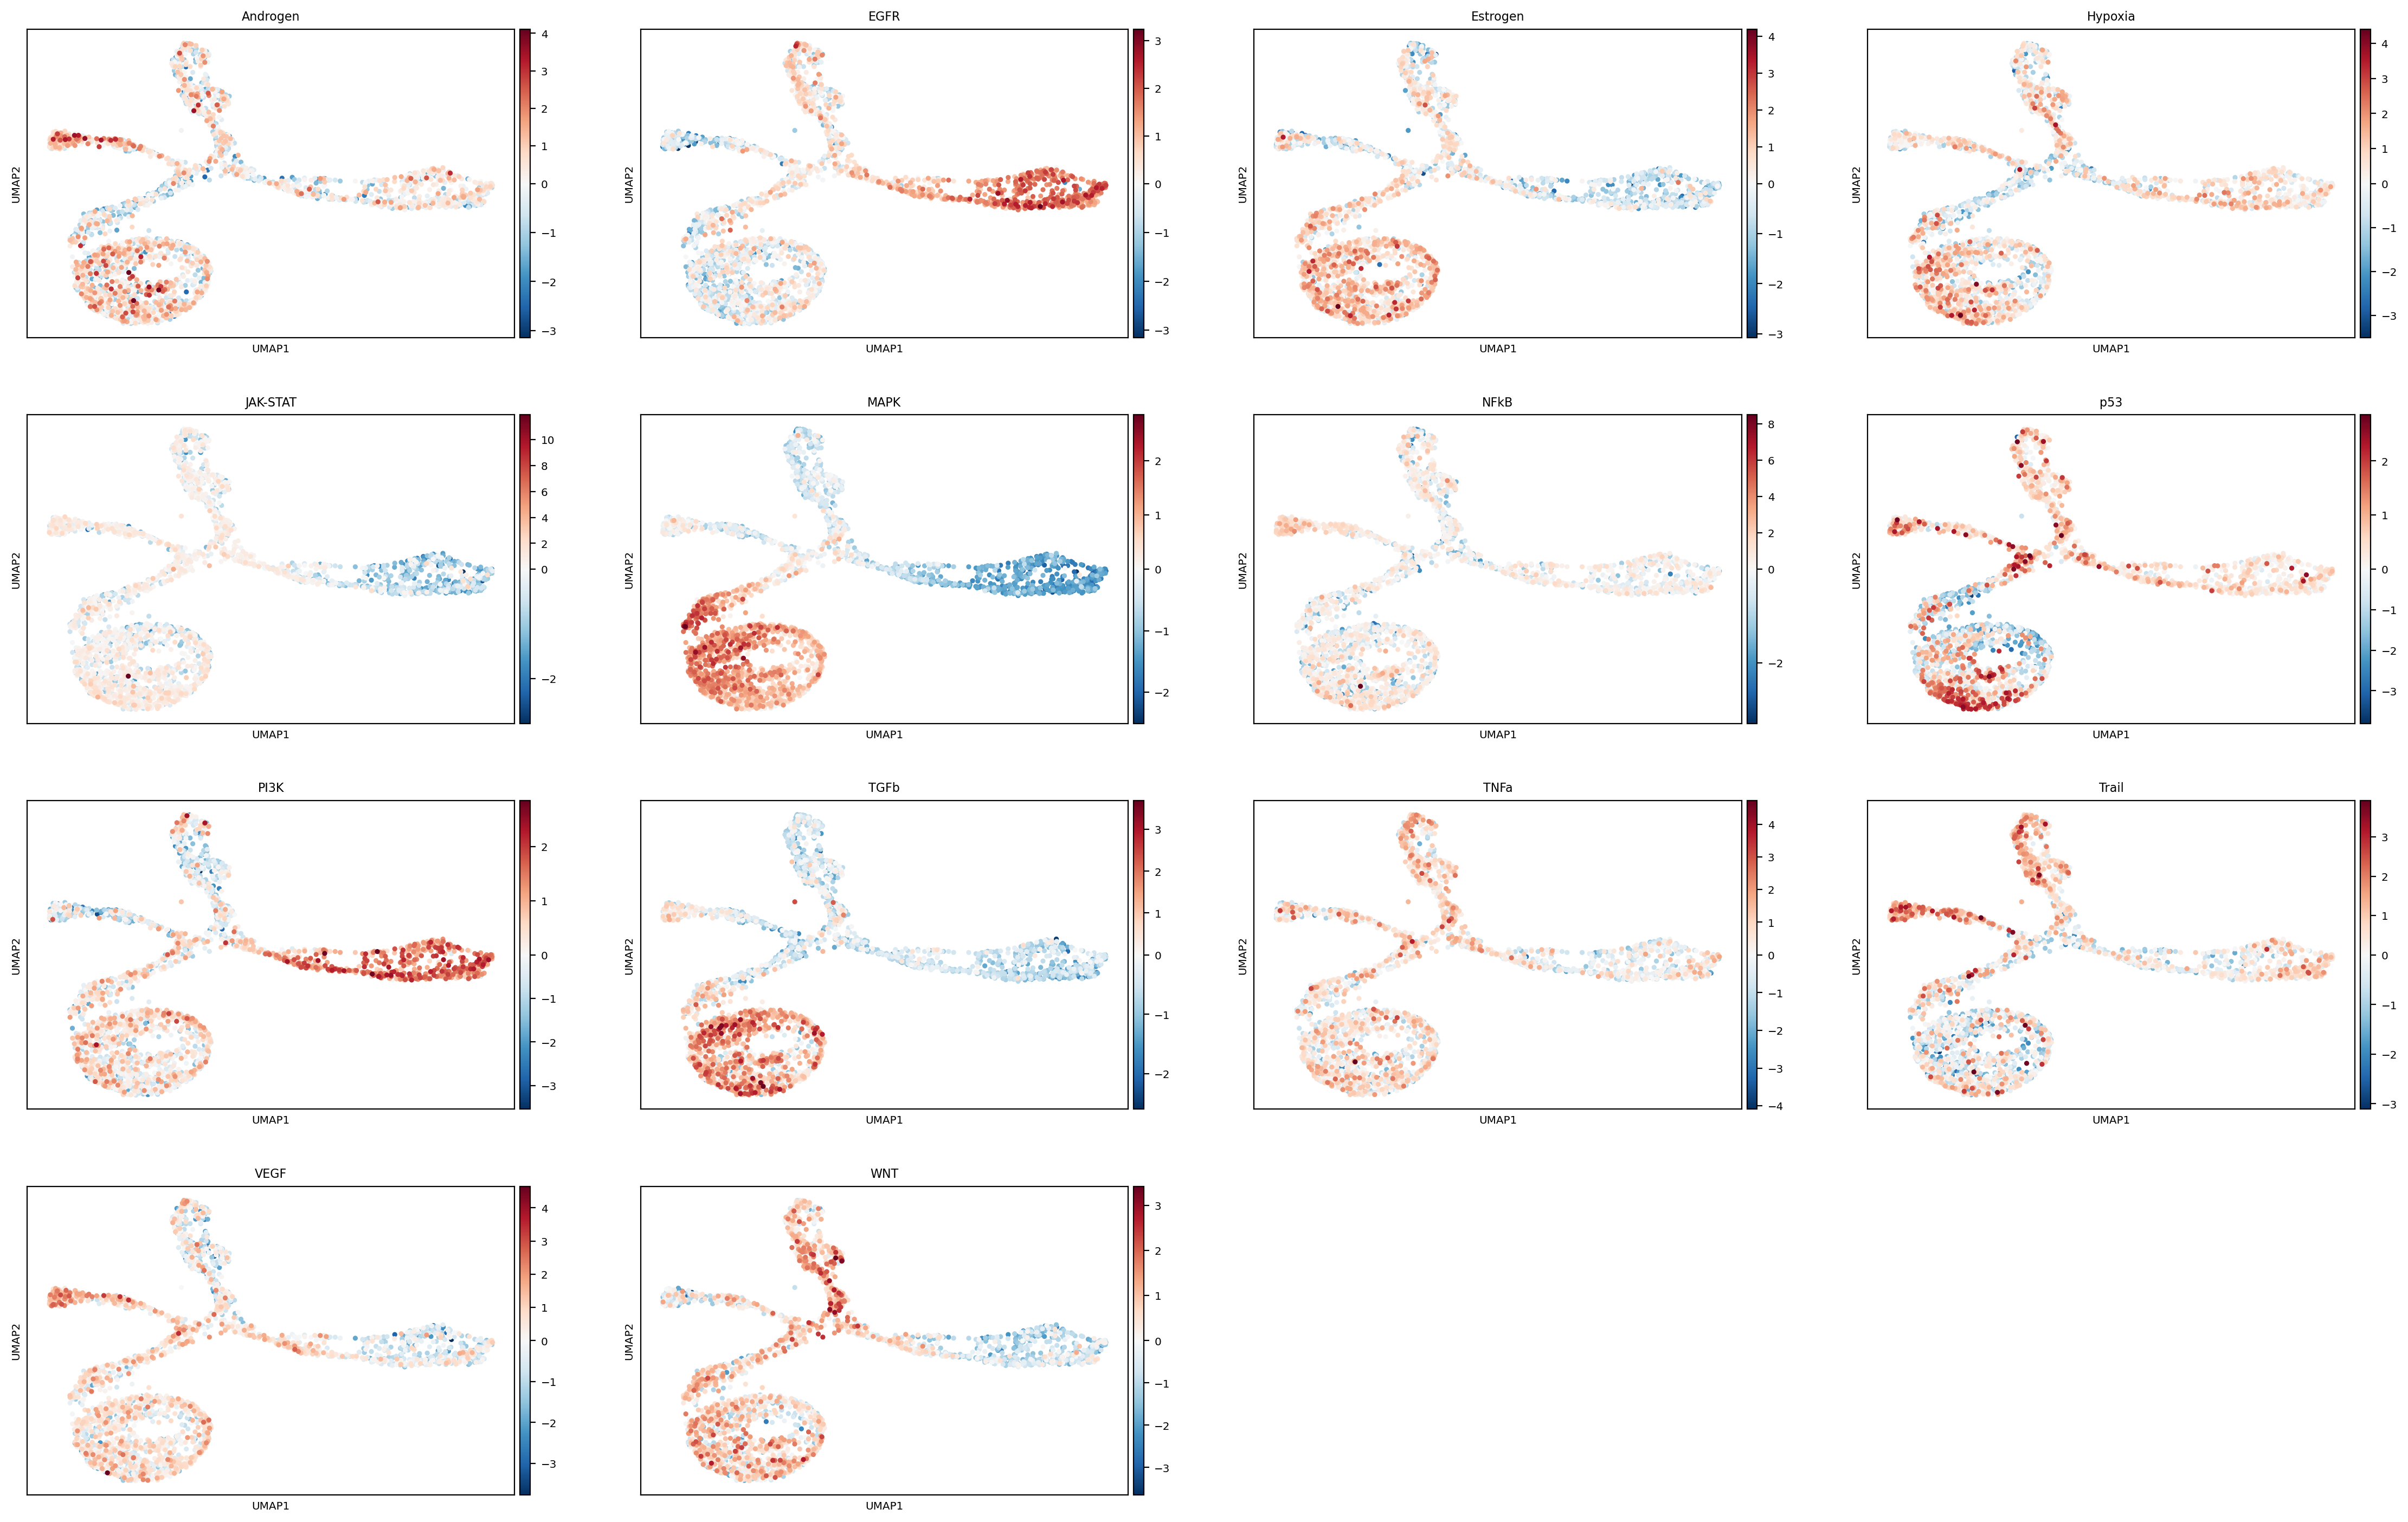

In [9]:
sc.pl.umap(acts, 
           color=['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB', 'p53', 'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT'], 
           cmap='RdBu_r', 
           vcenter=0)

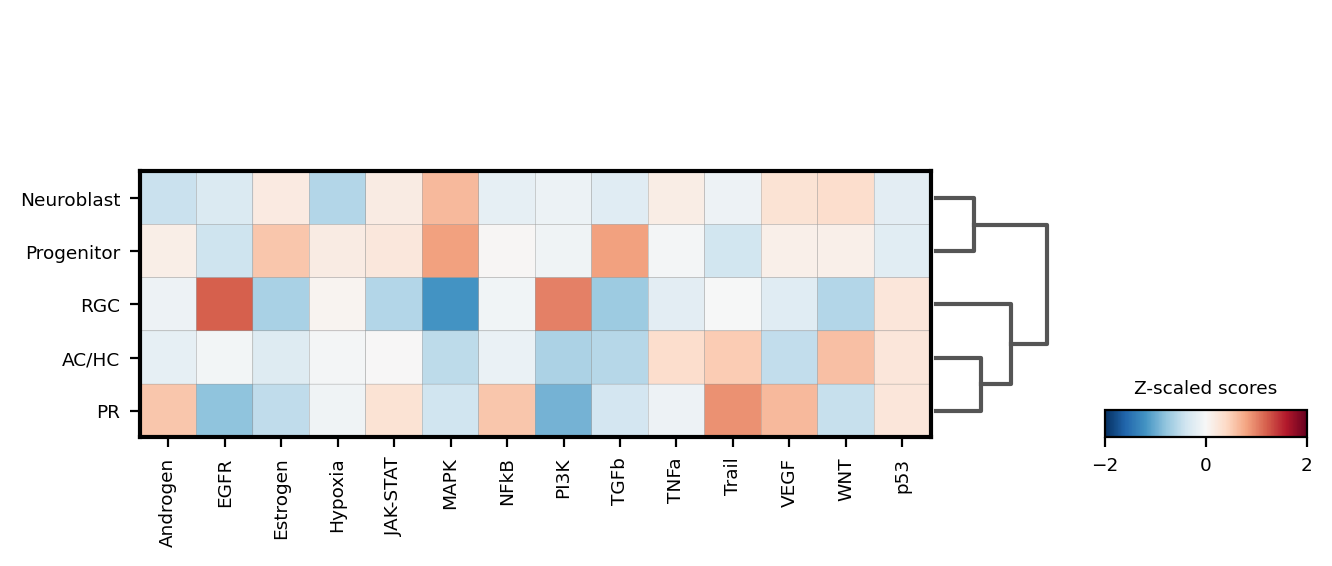

In [10]:
sc.pl.matrixplot(acts, 
                 var_names=acts.var_names, 
                 groupby='Annotation', 
                 dendrogram=True,
                 colorbar_title='Z-scaled scores', 
                 vmin=-2, 
                 vmax=2, 
                 cmap='RdBu_r',)

## Functional enrichment of biological terms

### MSigDB gene sets
The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [11]:
msigdb = dc.get_resource('MSigDB')

In [12]:
# Remove duplicated entries
msigdb_noFilter = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

### Enrichment with Over Representation Analysis (ORA)

run ora with a simple one-liner:

In [13]:
dc.run_ora(
    mat=adata,
    net=msigdb_noFilter,
    source='geneset',
    target='genesymbol',
    verbose=True)

14627 features of mat are empty, they will be removed.
Running ora on mat with 2726 samples and 16426 targets for 31264 sources.


100%|███████████████████████████████████████████████████████████| 2726/2726 [01:43<00:00, 26.26it/s]


### Visualization

In [14]:
noFilter_Functional_acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
noFilter_Functional_acts_v = noFilter_Functional_acts.X.ravel()
max_e = np.nanmax(noFilter_Functional_acts_v[np.isfinite(noFilter_Functional_acts_v)])
noFilter_Functional_acts.X[~np.isfinite(noFilter_Functional_acts.X)] = max_e

# We can scale the obtained activities for better visualizations
sc.pp.scale(noFilter_Functional_acts)
noFilter_Functional_acts

AnnData object with n_obs × n_vars = 2726 × 31264
    obs: 'Clusters', 'Annotation', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'mean', 'std'
    uns: 'paper_review_url', 'paper_url', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dendrogram_Annotation'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_scores', 'mlm_estimate', 'mlm_pvals', 'ora_estimate', 'ora_pvals'

In [15]:
noFilter_df = dc.rank_sources_groups(noFilter_Functional_acts, groupby='Annotation', reference='rest', method='t-test_overestim_var')

In [16]:
n_markers = 5
noFilter_source_markers = noFilter_df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()

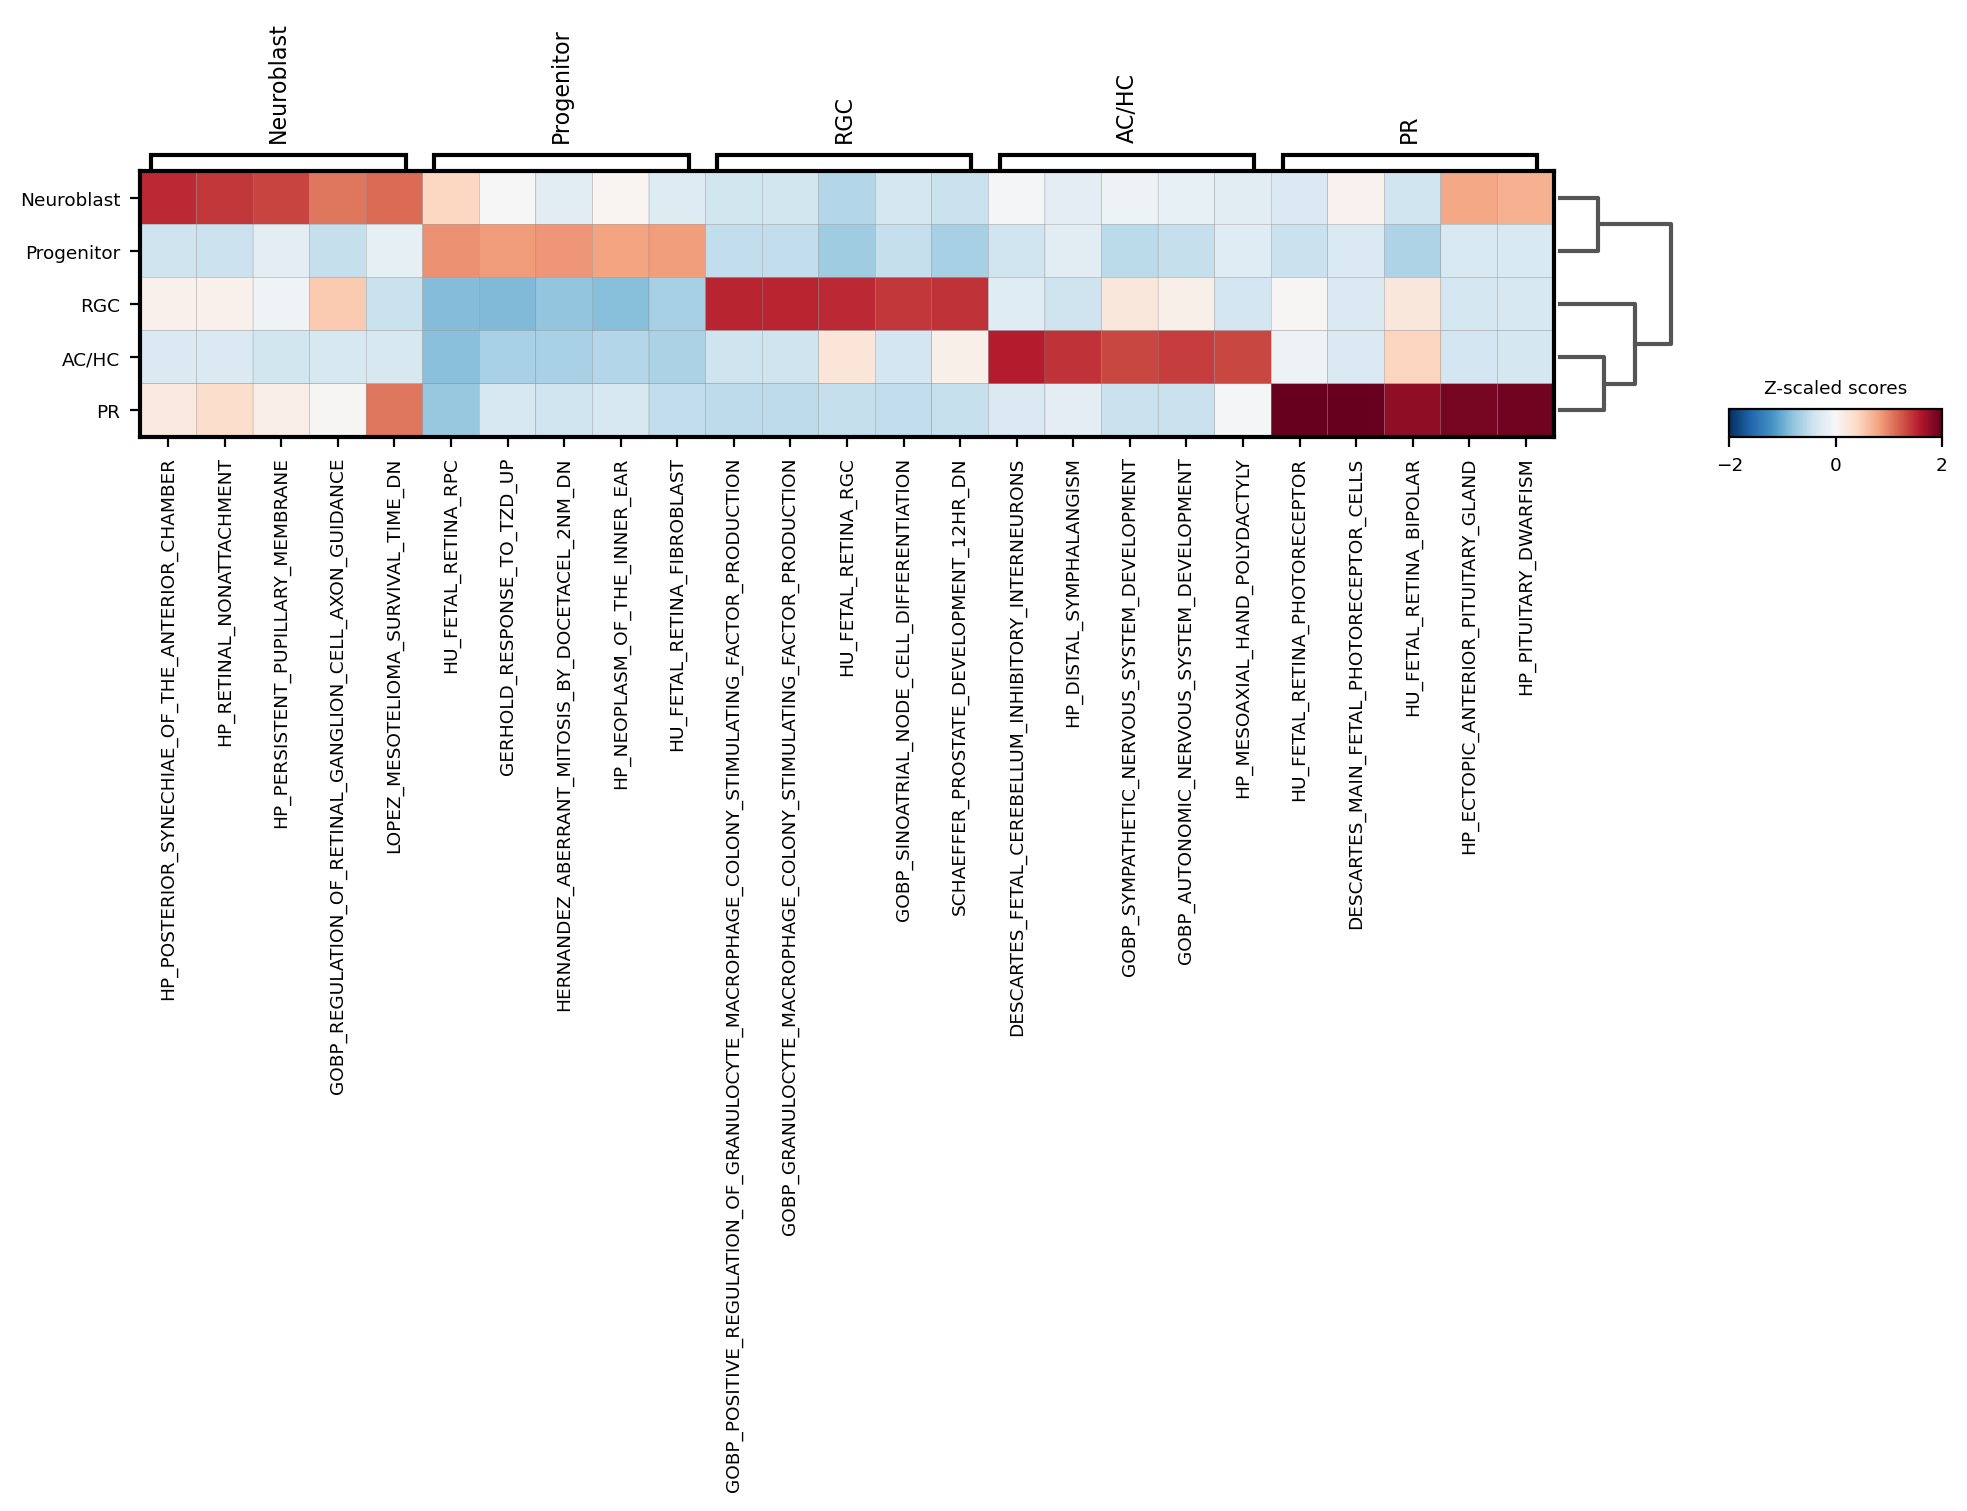

In [17]:
sc.pl.matrixplot(noFilter_Functional_acts, 
                 noFilter_source_markers, 
                 'Annotation', 
                 dendrogram=True,
                 colorbar_title='Z-scaled scores', 
                 vmin=-2, 
                 vmax=2, 
                 cmap='RdBu_r')